# ABCD - The Simple Case
A very simple ABCD method calculation: Build a dataset, define a cut, and then predict A from B, C, and D. The variables created are totally uncorrelated.

We define ABCD as A in the upper left hand quadrant, B in the lower left hand, C in the upper right hand and D in the lower right hand:

       +----+----+
       |  A |  C |
    v2 +----+----+
       |  B +  D |
       +---------+
           v1
   
 Thus, the ratio is A/B = C/D or A = BC/D.
 
     A: v1 <= xcut & v2 > ycut
     B: v1 <= xcut & v2 <= ycut
     C: v1 > xcut & v2 > ycut
     D: v1 > xcut & v2 <= ycut

## Initalization

In [138]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

## Sample Generation

In [7]:
def generate(n):
  sample_np = np.random.rand(n, 2)
  return pd.DataFrame(sample_np, columns=['v1', 'v2'])

In [8]:
sample=generate(10000)

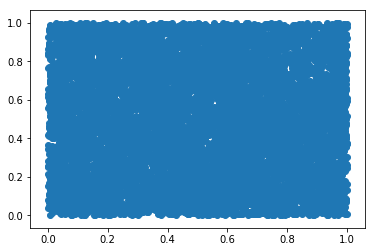

In [9]:
plt.scatter(sample['v1'], sample['v2'])

## ABCD Calculation

In [112]:
def calc_ABCD(s, xc, yc):
    A = s.loc[(s['v1']<=xc) & (s['v2']>yc)]
    B = s.loc[(s['v1']<=xc) & (s['v2']<=yc)]
    C = s.loc[(s['v1']>xc) & (s['v2']>yc)]
    D = s.loc[(s['v1']>xc) & (s['v2']<=yc)]
    nA = len(A.index)
    nB = len(B.index)
    nC = len(C.index)
    nD = len(D.index)
    if (nD == 0) | (nA == 0):
        fractionalError = 0
    else:
        pred = nB*nC/nD
        fractionalError = (nA - pred)/nA
    return fractionalError

In [113]:
xcut = 0.5
ycut = 0.5
calc_ABCD(sample, xcut, ycut)

0.01251466935512083

## Statstical Error

In [77]:
def ABCD_statistics (nS, xcut, ycut):
    s = generate(nS)
    return calc_ABCD(s, xcut, ycut)

In [94]:
stas = pd.DataFrame([ABCD_statistics(int(1000), xcut, ycut) for i in range(1000)], columns=['ABCD Fractional Error'])

In [95]:
mu, std = norm.fit(stas['ABCD Fractional Error'])

Text(0.5,1,'Fit results: mu = -0.00,  std = 0.13')

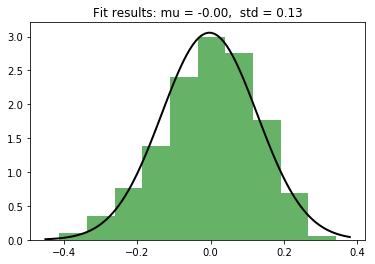

In [141]:
plt.hist(stas['ABCD Fractional Error'], normed=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

## Statistical Error and Sample Size

In [142]:
def ABCD_error (nS, nIter, xcut, ycut):
    stas = pd.DataFrame([ABCD_statistics(nS, xcut, ycut) for i in range(nIter)], columns=['ABCD Fractional Error'])
    mu, std = norm.fit(stas['ABCD Fractional Error'])
    return std

In [125]:
errors = pd.DataFrame(np.array([(ns, ABCD_error(ns, 100, 0.5, 0.5)) for ns in (20, 50, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000, 10000)]), columns=['nSamples', 'Error'])

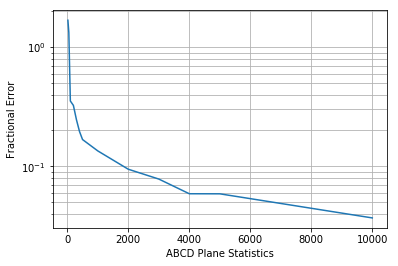

In [143]:
plt.plot(errors['nSamples'], errors['Error'])
plt.xlabel("ABCD Plane Statistics")
plt.ylabel("Fractional Error")
plt.yscale('log')
plt.grid(which='minor')
plt.grid()
plt.show()